In [1]:
import ast
import json
from pathlib import Path
from typing import Optional, Union

import numpy as np
import pandas as pd
import torch

import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import StandardScaler


In [6]:
# ===== MEMORY OPTIMIZATION =====

import gc
import os

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
gc.collect()

# Set memory management
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Reduce memory usage
if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.9)

print("✅ Memory optimizations applied")


✅ Memory optimizations applied


In [7]:
import os
CURRENT_DIR = '/home/s2320437/WORK/aidan-medaf/'
os.chdir(CURRENT_DIR)
print(f"Current working directory: {os.getcwd()}")


KNOWN_LABELS = [
    "Atelectasis",
    "Cardiomegaly",
    "Effusion",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pneumonia",
    "Pneumothorax",
]

DEFAULT_IMAGE_ROOT = Path(f"{CURRENT_DIR}/datasets/data/chestxray/NIH/images-224")
DEFAULT_KNOWN_CSV = Path(f"{CURRENT_DIR}/datasets/data/chestxray/NIH/chestxray_train_known.csv")

DEFAULT_CHECKPOINT_DIR = Path(f"{CURRENT_DIR}/checkpoints/medaf_phase1")



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = {}
train_loader = None
val_loader = None
test_loader = None
dataset_name = None
class_names = KNOWN_LABELS

print()

Current working directory: /home/s2320437/WORK/aidan-medaf



In [8]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from core.net import build_backbone, conv1x1, Classifier

class MultiLabelMEDAF(nn.Module):
    """
    Multi-Label version of MEDAF (Multi-Expert Diverse Attention Fusion)

    Key changes from original MEDAF:
    1. Support for multi-hot label targets
    2. BCEWithLogitsLoss instead of CrossEntropyLoss
    3. Multi-label attention diversity computation
    4. Per-sample CAM extraction for multiple positive classes
    """

    def __init__(self, args=None):
        super(MultiLabelMEDAF, self).__init__()
        backbone, feature_dim, self.cam_size = build_backbone(
            img_size=args["img_size"],
            backbone_name=args["backbone"],
            projection_dim=-1,
            inchan=3,
        )
        self.img_size = args["img_size"]
        self.gate_temp = args["gate_temp"]
        self.num_classes = args[
            "num_classes"
        ]  # Changed from num_known to num_classes for clarity
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # Shared layers (L1-L3)
        self.shared_l3 = nn.Sequential(*list(backbone.children())[:-6])

        # Expert branch 1
        self.branch1_l4 = nn.Sequential(*list(backbone.children())[-6:-3])
        self.branch1_l5 = nn.Sequential(*list(backbone.children())[-3])
        self.branch1_cls = conv1x1(feature_dim, self.num_classes)

        # Expert branch 2 (deep copy)
        self.branch2_l4 = copy.deepcopy(self.branch1_l4)
        self.branch2_l5 = copy.deepcopy(self.branch1_l5)
        self.branch2_cls = conv1x1(feature_dim, self.num_classes)

        # Expert branch 3 (deep copy)
        self.branch3_l4 = copy.deepcopy(self.branch1_l4)
        self.branch3_l5 = copy.deepcopy(self.branch1_l5)
        self.branch3_cls = conv1x1(feature_dim, self.num_classes)

        # Gating network
        self.gate_l3 = copy.deepcopy(self.shared_l3)
        self.gate_l4 = copy.deepcopy(self.branch1_l4)
        self.gate_l5 = copy.deepcopy(self.branch1_l5)
        self.gate_cls = nn.Sequential(
            Classifier(feature_dim, int(feature_dim / 4), bias=True),
            Classifier(int(feature_dim / 4), 3, bias=True),  # 3 experts
        )

    def forward(self, x, y=None, return_ft=False):
        """
        Forward pass for multi-label MEDAF

        Args:
            x: Input tensor [B, C, H, W]
            y: Multi-hot labels [B, num_classes] or None
            return_ft: Whether to return features

        Returns:
            Dictionary containing logits, gate predictions, and CAMs/features
        """
        b = x.size(0)
        ft_till_l3 = self.shared_l3(x)

        # Expert branch 1
        branch1_l4 = self.branch1_l4(ft_till_l3.clone())
        branch1_l5 = self.branch1_l5(branch1_l4)
        b1_ft_cams = self.branch1_cls(branch1_l5)  # [B, num_classes, H, W]
        b1_logits = self.avg_pool(b1_ft_cams).view(b, -1)

        # Expert branch 2
        branch2_l4 = self.branch2_l4(ft_till_l3.clone())
        branch2_l5 = self.branch2_l5(branch2_l4)
        b2_ft_cams = self.branch2_cls(branch2_l5)  # [B, num_classes, H, W]
        b2_logits = self.avg_pool(b2_ft_cams).view(b, -1)

        # Expert branch 3
        branch3_l4 = self.branch3_l4(ft_till_l3.clone())
        branch3_l5 = self.branch3_l5(branch3_l4)
        b3_ft_cams = self.branch3_cls(branch3_l5)  # [B, num_classes, H, W]
        b3_logits = self.avg_pool(b3_ft_cams).view(b, -1)

        # Store CAMs for diversity loss computation
        cams_list = [b1_ft_cams, b2_ft_cams, b3_ft_cams]

        # Multi-label CAM extraction for positive classes
        if y is not None:
            # Extract CAMs for all positive classes across all experts
            # This will be used for attention diversity computation
            multi_label_cams = self._extract_multilabel_cams(cams_list, y)
        else:
            multi_label_cams = None

        if return_ft:
            # Aggregate features from all experts
            fts = (
                b1_ft_cams.detach().clone()
                + b2_ft_cams.detach().clone()
                + b3_ft_cams.detach().clone()
            )

        # Gating network
        gate_l5 = self.gate_l5(self.gate_l4(self.gate_l3(x)))
        gate_pool = self.avg_pool(gate_l5).view(b, -1)
        gate_pred = F.softmax(self.gate_cls(gate_pool) / self.gate_temp, dim=1)

        # Adaptive fusion using gating weights
        gate_logits = torch.stack(
            [b1_logits.detach(), b2_logits.detach(), b3_logits.detach()], dim=-1
        )
        gate_logits = gate_logits * gate_pred.view(
            gate_pred.size(0), 1, gate_pred.size(1)
        )
        gate_logits = gate_logits.sum(-1)

        logits_list = [b1_logits, b2_logits, b3_logits, gate_logits]

        if return_ft and y is None:
            outputs = {
                "logits": logits_list,
                "gate_pred": gate_pred,
                "fts": fts,
                "cams_list": cams_list,
            }
        else:
            outputs = {
                "logits": logits_list,
                "gate_pred": gate_pred,
                "multi_label_cams": multi_label_cams,
                "cams_list": cams_list,
            }

        return outputs

    def _extract_multilabel_cams(self, cams_list, targets):
        """
        Extract CAMs for all positive classes in multi-label setting

        Args:
            cams_list: List of CAMs from 3 experts [B, num_classes, H, W]
            targets: Multi-hot labels [B, num_classes]

        Returns:
            extracted_cams: List of CAMs for positive classes per expert
        """
        batch_size = targets.size(0)
        extracted_cams = []

        for expert_idx, expert_cams in enumerate(cams_list):
            expert_extracted = []

            for batch_idx in range(batch_size):
                # Find positive class indices for this sample
                positive_classes = torch.where(targets[batch_idx] == 1)[0]

                if len(positive_classes) > 0:
                    # Extract CAMs for positive classes
                    sample_cams = expert_cams[
                        batch_idx, positive_classes
                    ]  # [num_positive, H, W]
                    expert_extracted.append(sample_cams)
                else:
                    # If no positive classes, create zero tensor
                    H, W = expert_cams.shape[-2:]
                    expert_extracted.append(
                        torch.zeros(1, H, W, device=expert_cams.device)
                    )

            extracted_cams.append(expert_extracted)

        return extracted_cams

    def get_params(self, prefix="extractor"):
        """Get model parameters for different learning rates"""
        extractor_params = (
            list(self.shared_l3.parameters())
            + list(self.branch1_l4.parameters())
            + list(self.branch1_l5.parameters())
            + list(self.branch2_l4.parameters())
            + list(self.branch2_l5.parameters())
            + list(self.branch3_l4.parameters())
            + list(self.branch3_l5.parameters())
            + list(self.gate_l3.parameters())
            + list(self.gate_l4.parameters())
            + list(self.gate_l5.parameters())
        )
        extractor_params_ids = list(map(id, extractor_params))
        classifier_params = filter(
            lambda p: id(p) not in extractor_params_ids, self.parameters()
        )

        if prefix in ["extractor", "extract"]:
            return extractor_params
        elif prefix in ["classifier"]:
            return classifier_params


In [9]:
# Dataset: ChestXrayKnownDataset
class ChestXrayKnownDataset(data.Dataset):
    """Dataset that reads the known-label ChestX-ray14 split for Phase 1 training."""

    def __init__(
        self,
        csv_path: Path,
        image_root: Path,
        img_size: int = 224,
        max_samples: Optional[int] = None,
        transform=None,
    ) -> None:
        self.csv_path = Path(csv_path)
        self.image_root = Path(image_root)
        self.img_size = img_size
        self.class_names = KNOWN_LABELS
        self.num_classes = len(self.class_names)


        if not self.csv_path.exists():
            raise FileNotFoundError(f"ChestX-ray CSV not found: {self.csv_path}")
        if not self.image_root.exists():
            raise FileNotFoundError(
                f"ChestX-ray image directory not found: {self.image_root}"
            )

        if transform is None:
            self.transform = transforms.Compose(
                [
                    transforms.Resize((img_size, img_size)),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                ]
            )
        else:
            self.transform = transform

        df = pd.read_csv(self.csv_path)
        if "known_labels" not in df.columns:
            raise ValueError(
                "Expected 'known_labels' column in CSV. Run utils/create_chestxray_splits.py first."
            )

        if max_samples is not None and max_samples < len(df):
            df = df.sample(n=max_samples, random_state=42).reset_index(drop=True)
        else:
            df = df.reset_index(drop=True)

        self.records = df.to_dict("records")
        self.label_to_idx = {label: idx for idx, label in enumerate(self.class_names)}
        print(f"Label to index: {self.label_to_idx}")

    @staticmethod
    def _parse_label_list(raw_value):
        if isinstance(raw_value, list):
            return raw_value
        if pd.isna(raw_value):
            return []
        if isinstance(raw_value, str):
            raw_value = raw_value.strip()
            if not raw_value:
                return []
            try:
                parsed = ast.literal_eval(raw_value)
                if isinstance(parsed, (list, tuple)):
                    return list(parsed)
                if isinstance(parsed, str):
                    return [parsed]
            except (ValueError, SyntaxError):
                pass
            return [item.strip() for item in raw_value.split("|") if item.strip()]
        return []

    def __len__(self) -> int:
        return len(self.records)

    def __getitem__(self, idx):
        record = self.records[idx]
        image_path = self.image_root / record["Image Index"]
        if not image_path.exists():
            raise FileNotFoundError(f"Missing image: {image_path}")

        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        labels = torch.zeros(self.num_classes, dtype=torch.float32)
        for label in self._parse_label_list(record.get("known_labels", [])):
            if label in self.label_to_idx:
                labels[self.label_to_idx[label]] = 1.0

        return image, labels

    # class_name
    @staticmethod
    def class_name():
        return KNOWN_LABELS


In [10]:
 # Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
# Demo configuration
config = {
    "data_source": "chestxray",
    "known_csv": str(DEFAULT_KNOWN_CSV),
    "image_root": str(DEFAULT_IMAGE_ROOT),
    "batch_size": 32,
    "num_epochs": 50,
    "learning_rate": 1e-4,
    "val_ratio": 0.1,
    "num_workers": 1,
    # "max_samples": None,  # Set to an int for quicker experiments
    # "max_samples": 1000,
    "phase1_checkpoint": "medaf_phase1_chestxray.pt",
    "checkpoint_dir": str(DEFAULT_CHECKPOINT_DIR),
    "run_phase2": False,
}

In [11]:
data_source = config.get("data_source", "chestxray").lower()

if data_source == "chestxray":
    csv_path = Path(config.get("known_csv", DEFAULT_KNOWN_CSV))
    image_root = Path(config.get("image_root", DEFAULT_IMAGE_ROOT))
    max_samples = config.get("max_samples")
    if isinstance(max_samples, str):
        max_samples = int(max_samples)
    print(f"Loading ChestX-ray14 known-label split from {csv_path}")
    dataset = ChestXrayKnownDataset(
        csv_path=csv_path,
        image_root=image_root,
        img_size=config.get("img_size", 224),
        max_samples=max_samples,
    )
    dataset_name = "ChestX-ray14 (known labels)"
    class_names = dataset.class_names
    config["num_classes"] = dataset.num_classes
    config["img_size"] = dataset.img_size

val_ratio = float(config.get("val_ratio", 0.1))
val_size = max(1, int(len(dataset) * val_ratio))
train_size = len(dataset) - val_size

train_dataset, val_dataset = data.random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

batch_size = config.get("batch_size", 16)
num_workers = config.get("num_workers", 4)
pin_memory = torch.cuda.is_available()

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_loader = val_loader

print(
    f"Dataset prepared: {train_size} train / {val_size} val samples ({dataset_name})"
)


Loading ChestX-ray14 known-label split from /home/s2320437/WORK/aidan-medaf/datasets/data/chestxray/NIH/chestxray_train_known.csv
Label to index: {'Atelectasis': 0, 'Cardiomegaly': 1, 'Effusion': 2, 'Infiltration': 3, 'Mass': 4, 'Nodule': 5, 'Pneumonia': 6, 'Pneumothorax': 7}
Dataset prepared: 96294 train / 10699 val samples (ChestX-ray14 (known labels))


In [12]:
def save_model(model, args, loss_history):
    ckpt_dir = Path(config["checkpoint_dir"])
    ckpt_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_path = ckpt_dir / config["phase1_checkpoint"]

    payload = {
        "state_dict": model.state_dict(),
        "args": args,
        "class_names": class_names,
        "dataset": dataset_name,
    }
    torch.save(payload, checkpoint_path)

    metadata = {
        "dataset": dataset_name,
        "class_names": class_names,
        "num_epochs": config["num_epochs"],
        "batch_size": config.get("batch_size"),
        "learning_rate": config.get("learning_rate"),
        "loss_history": [float(loss) for loss in loss_history],
        "device": str(device),
        "checkpoint": str(checkpoint_path),
        "config": {
            k: v
            for k, v in config.items()
            if isinstance(v, (int, float, str, bool))
        },
    }
    metadata_path = checkpoint_path.with_suffix(".json")
    with metadata_path.open("w", encoding="utf-8") as fp:
        json.dump(metadata, fp, indent=2)

    return checkpoint_path

In [13]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from misc.util import *


def multiLabelAttnDiv(cams_list, targets, eps=1e-6):
    """
    Multi-label attention diversity loss

    Encourages different experts to focus on different spatial regions
    for all positive classes in multi-label setting.

    Args:
        cams_list: List of CAMs from 3 experts [B, num_classes, H, W]
        targets: Multi-hot labels [B, num_classes]
        eps: Small value for numerical stability

    Returns:
        diversity_loss: Scalar tensor representing attention diversity loss
    """
    if targets is None or targets.sum() == 0:
        return torch.tensor(0.0, device=cams_list[0].device)

    cos = nn.CosineSimilarity(dim=1, eps=eps)
    diversity_loss = 0.0
    total_pairs = 0
    batch_size = targets.size(0)

    for batch_idx in range(batch_size):
        # Get positive class indices for this sample
        positive_classes = torch.where(targets[batch_idx] == 1)[0]

        if len(positive_classes) == 0:
            continue

        # Process each positive class
        for class_idx in positive_classes:
            # Extract CAMs for this class from all experts
            expert_cams = torch.stack(
                [
                    cams_list[0][batch_idx, class_idx],  # Expert 1: [H, W]
                    cams_list[1][batch_idx, class_idx],  # Expert 2: [H, W]
                    cams_list[2][batch_idx, class_idx],  # Expert 3: [H, W]
                ]
            )  # [3, H, W]

            # Flatten spatial dimensions and normalize
            expert_cams = expert_cams.view(3, -1)  # [3, H*W]
            expert_cams = F.normalize(expert_cams, p=2, dim=-1)

            # Remove mean activation to focus on relative attention patterns
            mean = expert_cams.mean(dim=-1, keepdim=True)  # [3, 1]
            expert_cams = F.relu(expert_cams - mean)

            # Compute pairwise cosine similarity (encourage orthogonality)
            for i in range(3):
                for j in range(i + 1, 3):
                    similarity = cos(
                        expert_cams[i : i + 1], expert_cams[j : j + 1]
                    ).mean()
                    diversity_loss += similarity
                    total_pairs += 1

    # Average over all pairs
    if total_pairs > 0:
        return diversity_loss / total_pairs
    else:
        return torch.tensor(0.0, device=cams_list[0].device)



In [14]:

def multiLabelAccuracy(predictions, targets, threshold=0.5):
    """
    Compute multi-label accuracy metrics for MEDAF model evaluation
    
    This function calculates different types of accuracy for multi-label classification:
    - Subset Accuracy: Strictest metric - ALL predicted labels must match ground truth
    - Hamming Accuracy: More lenient - average accuracy across all label predictions
    - Precision/Recall/F1: Standard classification metrics averaged across classes

    Args:
        predictions: Model predictions [B, num_classes] (logits from expert/gate)
        targets: Multi-hot ground truth [B, num_classes] (0/1 for each disease class)
        threshold: Threshold for converting probabilities to binary predictions (default: 0.5)

    Returns:
        subset_acc: Exact match accuracy (all labels correct) - used in training output
        hamming_acc: Label-wise accuracy (not used in training output)
        precision: Precision score (not used in training output)
        recall: Recall score (not used in training output)
        f1: F1 score (not used in training output)
    """
    with torch.no_grad():
        # Convert logits to probabilities using sigmoid (multi-label setting)
        probs = torch.sigmoid(predictions)
        pred_binary = (probs > threshold).float()  # Convert to binary predictions

        # Subset accuracy (exact match) - STRICTEST METRIC
        # A sample is correct only if ALL predicted labels match ground truth exactly
        # Example: If ground truth is [1,0,1,0] and prediction is [1,0,1,0] → correct
        #          If ground truth is [1,0,1,0] and prediction is [1,0,0,0] → incorrect
        subset_acc = (pred_binary == targets).all(dim=1).float().mean()

        # Hamming accuracy (label-wise accuracy) - MORE LENIENT
        # Average accuracy across all individual label predictions
        # Example: If ground truth is [1,0,1,0] and prediction is [1,0,0,0] → 3/4 = 75%
        hamming_acc = (pred_binary == targets).float().mean()

        # Precision, Recall, F1 - Standard classification metrics
        tp = (pred_binary * targets).sum(dim=0)      # True positives per class
        fp = (pred_binary * (1 - targets)).sum(dim=0)  # False positives per class
        fn = ((1 - pred_binary) * targets).sum(dim=0)  # False negatives per class

        precision = tp / (tp + fp + 1e-8)  # Precision per class
        recall = tp / (tp + fn + 1e-8)     # Recall per class
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)  # F1 per class

        # Average across all classes
        precision = precision.mean()
        recall = recall.mean()
        f1 = f1.mean()

    return subset_acc, hamming_acc, precision, recall, f1



In [15]:

def train_multilabel(train_loader, model, criterion, optimizer, args, device=None):
    """
    Training loop for multi-label MEDAF (Multi-Expert Diverse Attention Fusion)
    
    This function trains a multi-expert model where:
    - 3 Expert branches (b1, b2, b3) learn different representations
    - 1 Gating network adaptively fuses expert predictions
    - Attention diversity loss encourages experts to focus on different regions

    Args:
        train_loader: DataLoader with multi-label data
        model: MultiLabelMEDAF model
        criterion: Dictionary containing loss functions
        optimizer: Optimizer
        args: Training arguments
        device: Device to run on

    Returns:
        Average training loss
    """
    model.train()

    # Loss tracking keys: ["b1", "b2", "b3", "gate", "divAttn", "total"]
    # - b1, b2, b3: Individual expert branch losses (BCE for multi-label classification)
    # - gate: Gating network loss (BCE for fused predictions)
    # - divAttn: Attention diversity loss (encourages different spatial attention patterns)
    # - total: Weighted combination of all losses
    loss_keys = args["loss_keys"]
    
    # Accuracy tracking keys: ["acc1", "acc2", "acc3", "accGate"]
    # - acc1, acc2, acc3: Subset accuracy for each expert branch (exact label match)
    # - accGate: Subset accuracy for gating network (fused predictions)
    acc_keys = args["acc_keys"]

    loss_meter = {p: AverageMeter() for p in loss_keys}
    acc_meter = {p: AverageMeter() for p in acc_keys}
    time_start = time.time()

    for i, data in enumerate(train_loader):
        inputs = data[0].to(device)
        targets = data[1].to(device)  # Multi-hot labels [B, num_classes]

        # Forward pass through MEDAF model
        output_dict = model(inputs, targets)
        logits = output_dict["logits"]  # List of logits from 4 heads: [b1, b2, b3, gate]
        cams_list = output_dict["cams_list"]  # CAMs from 3 experts for attention diversity

        # ===== LOSS COMPUTATION =====
        
        # Expert branch losses (b1, b2, b3): BCE loss for multi-label classification
        # Each expert learns to predict all disease classes independently
        bce_losses = [
            criterion["bce"](logit.float(), targets.float())
            for logit in logits[:3]  # Expert branches only (b1, b2, b3)
        ]

        # Gating network loss (gate): BCE loss for adaptively fused predictions
        # The gating network learns to combine expert predictions optimally
        gate_loss = criterion["bce"](logits[3].float(), targets.float())

        # Attention diversity loss (divAttn): Encourages experts to focus on different regions
        # Lower values = more diverse attention patterns across experts
        diversity_loss = multiLabelAttnDiv(cams_list, targets)

        # Combine all losses with predefined weights
        # loss_wgts = [0.7, 1.0, 0.01] for [expert_weight, gate_weight, diversity_weight]
        loss_values = bce_losses + [gate_loss, diversity_loss]
        total_loss = (
            args["loss_wgts"][0] * sum(bce_losses)  # Expert loss weight (0.7)
            + args["loss_wgts"][1] * gate_loss      # Gating loss weight (1.0)
            + args["loss_wgts"][2] * diversity_loss # Diversity loss weight (0.01)
        )
        loss_values.append(total_loss)

        # ===== ACCURACY COMPUTATION =====
        
        # Compute subset accuracy for each prediction head
        # Subset accuracy = percentage of samples where ALL predicted labels match ground truth
        acc_values = []
        for logit in logits:
            subset_acc, hamming_acc, _, _, _ = multiLabelAccuracy(logit, targets)
            acc_values.append(subset_acc * 100)  # Convert to percentage

        # Update running averages for all metrics
        multi_loss = {loss_keys[k]: loss_values[k] for k in range(len(loss_keys))}
        train_accs = {acc_keys[k]: acc_values[k] for k in range(len(acc_keys))}

        update_meter(loss_meter, multi_loss, inputs.size(0))
        update_meter(acc_meter, train_accs, inputs.size(0))

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Print progress every 50 batches
        if i % 50 == 0:
            tmp_str = f"Batch [{i}/{len(train_loader)}] "
            tmp_str += "< Training Loss >\n"
            for k, v in loss_meter.items():
                tmp_str += f"{k}:{v.value:.4f} "
            tmp_str += "\n< Training Accuracy >\n"
            for k, v in acc_meter.items():
                tmp_str += f"{k}:{v.value:.1f} "
            print(tmp_str)

    time_elapsed = time.time() - time_start
    print(f"\nEpoch completed in {time_elapsed:.1f}s")

    # Final epoch summary
    tmp_str = "< Final Training Loss >\n"
    for k, v in loss_meter.items():
        tmp_str += f"{k}:{v.value:.4f} "
    tmp_str += "\n< Final Training Accuracy >\n"
    for k, v in acc_meter.items():
        tmp_str += f"{k}:{v.value:.1f} "
    print(tmp_str)

    return loss_meter[loss_keys[-1]].value


In [ ]:
"""Demonstrate Phase 1: Basic Multi-Label MEDAF"""
print("\n" + "=" * 60)
print("PHASE 1: Basic Multi-Label MEDAF")
print("=" * 60)

# Configuration for Phase 1
args = {
    "img_size": config["img_size"],
    "backbone": "resnet18",
    "num_classes": config["num_classes"],
    "gate_temp": 100,
    "loss_keys": ["b1", "b2", "b3", "gate", "divAttn", "total"],
    "acc_keys": ["acc1", "acc2", "acc3", "accGate"],
    # [expert_weight, gate_weight, diversity_weight] = 0.7 * (b1, b2, b3) + 1.0 * (gate) + 0.01 * (divAttn)
    "loss_wgts": [0.7, 1.0, 0.01], 
}

# Create Phase 1 model
model = MultiLabelMEDAF(args)
model.to(device)

print(
    f"Phase 1 Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
)

# Training setup
criterion = {"bce": nn.BCEWithLogitsLoss()}
optimizer = torch.optim.Adam(
    model.parameters(), lr=config["learning_rate"]
)

# Training
phase1_metrics = []
for epoch in range(config["num_epochs"]):
    metrics = train_multilabel(
        train_loader, model, criterion, optimizer, args, device
    )
    phase1_metrics.append(metrics)

    if epoch % 2 == 0:
        print(f"Epoch {epoch}: Loss={metrics:.4f}")

final_loss = phase1_metrics[-1] if phase1_metrics else float("nan")
checkpoint_path = save_model(model, args, phase1_metrics)

results["phase1"] = {
    "model": model,
    "final_loss": final_loss,
    "metrics_history": phase1_metrics,
    "checkpoint": str(checkpoint_path),
}
print('-'*40)
print('\n\n')
if phase1_metrics:
    print(f"Phase 1 Final Loss: {final_loss:.4f}")
else:
    print("Phase 1 completed with zero epochs (no training performed)")
print(f"Phase 1 checkpoint saved to: {checkpoint_path}")
print(
    "Use load_phase1_checkpoint(CheckpointPath) to reload this model for evaluation."
)


PHASE 1: Basic Multi-Label MEDAF
Making resnet layer with channel 64 block 2 stride 1
Making resnet layer with channel 128 block 2 stride 2
Making resnet layer with channel 256 block 2 stride 2
Making resnet layer with channel 512 block 2 stride 2
Phase 1 Model Parameters: 44,749,955
Batch [0/3010] < Training Loss >
b1:0.8761 b2:0.7285 b3:0.5811 gate:0.7074 divAttn:0.3422 total:2.2407 
< Training Accuracy >
acc1:0.0 acc2:0.0 acc3:3.1 accGate:0.0 
Batch [50/3010] < Training Loss >
b1:0.3201 b2:0.2933 b3:0.2786 gate:0.2930 divAttn:0.4527 total:0.9219 
< Training Accuracy >
acc1:51.3 acc2:52.5 acc3:53.7 accGate:53.3 
Batch [100/3010] < Training Loss >
b1:0.2862 b2:0.2718 b3:0.2643 gate:0.2715 divAttn:0.3360 total:0.8505 
< Training Accuracy >
acc1:54.2 acc2:54.7 acc3:55.4 accGate:55.2 
Batch [150/3010] < Training Loss >
b1:0.2759 b2:0.2664 b3:0.2609 gate:0.2658 divAttn:0.2805 total:0.8308 
< Training Accuracy >
acc1:54.5 acc2:54.9 acc3:55.3 accGate:55.2 
Batch [200/3010] < Training Loss 

In [ ]:
print('-'*10)

----------


# ===== EVALUATION FUNCTIONS =====

In [ ]:
def print_evaluation_results(results):
    """Print comprehensive evaluation results"""
    print("\n" + "="*60)
    print("🎯 MEDAF MODEL EVALUATION RESULTS")
    print("="*60)
    
    # Overall metrics
    overall = results['overall']
    print(f"\n📊 Overall Performance:")
    print(f"   Subset Accuracy:  {overall['subset_accuracy']:.4f} ({overall['subset_accuracy']*100:.2f}%)")
    print(f"   Hamming Accuracy: {overall['hamming_accuracy']:.4f} ({overall['hamming_accuracy']*100:.2f}%)")
    print(f"   Precision:        {overall['precision']:.4f}")
    print(f"   Recall:           {overall['recall']:.4f}")
    print(f"   F1-Score:         {overall['f1_score']:.4f}")
    print(f"   Average Loss:     {overall['average_loss']:.4f}")
    
    # Per-expert comparison
    print(f"\n🔬 Per-Expert Performance:")
    for expert_name, expert_metrics in results['per_expert'].items():
        print(f"   {expert_name:>8}: Subset={expert_metrics['subset_accuracy']:.4f}, "
                f"Hamming={expert_metrics['hamming_accuracy']:.4f}")
    
    # Per-class metrics
    print(f"\n🏷️  Per-Class Performance:")
    class_names = results['class_names']
    precision = results['per_class']['precision']
    recall = results['per_class']['recall']
    f1_score = results['per_class']['f1_score']
    
    print(f"   {'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("   " + "-"*50)
    
    for i, class_name in enumerate(class_names):
        print(f"   {class_name:<15} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1_score[i]:<10.4f}")
    
    # Best performing classes
    best_f1_idx = max(range(len(f1_score)), key=lambda i: f1_score[i])
    worst_f1_idx = min(range(len(f1_score)), key=lambda i: f1_score[i])
    
    print(f"\n🏆 Best Class:  {class_names[best_f1_idx]} (F1={f1_score[best_f1_idx]:.4f})")
    print(f"📉 Worst Class: {class_names[worst_f1_idx]} (F1={f1_score[worst_f1_idx]:.4f})")


def load_and_evaluate_checkpoint(checkpoint_path, data_loader, device, class_names=None):
    """
    Load a saved checkpoint and evaluate it
    
    Args:
        checkpoint_path: Path to saved model checkpoint
        data_loader: DataLoader for evaluation
        device: Device to run evaluation on
        class_names: List of class names
    
    Returns:
        Evaluation results dictionary
    """
    print(f"📁 Loading checkpoint from: {checkpoint_path}")
    
    try:
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        # Extract model arguments
        args = checkpoint.get('args', {})
        if not args:
            raise ValueError("Checkpoint missing 'args' - cannot reconstruct model")
        
        # Create model
        model = MultiLabelMEDAF(args)
        model.load_state_dict(checkpoint['state_dict'])
        model.to(device)
        
        print(f"✅ Model loaded successfully")
        print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
        print(f"   Dataset: {checkpoint.get('dataset', 'Unknown')}")
        print(f"   Classes: {checkpoint.get('class_names', 'Unknown')}")
        
        # Evaluate model
        results = evaluate_multilabel(model, data_loader, device, class_names)
        
        return results, model
        
    except Exception as e:
        print(f"❌ Error loading checkpoint: {e}")
        return None, None



In [ ]:
def evaluate_medaf_final(model, data_loader, device, class_names, threshold=0.1):
    """Final clean evaluation function - removes all duplicates"""
    model.eval()
    
    print(f"🔍 FINAL EVALUATION (Threshold: {threshold})")
    print("="*50)
    
    all_predictions = []
    all_targets = []
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            output_dict = model(inputs, targets)
            gate_logits = output_dict["logits"][-1]  # Use gating network
            
            # Convert to predictions
            probs = torch.sigmoid(gate_logits)
            pred_binary = (probs > threshold).float()
            
            # Store data
            all_predictions.append(pred_binary.cpu())
            all_targets.append(targets.cpu())
            
            # Compute loss
            criterion = nn.BCEWithLogitsLoss()
            loss = criterion(gate_logits, targets.float())
            total_loss += loss.item()
            num_batches += 1
    
    # Concatenate all data
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    # Compute metrics
    subset_acc = (all_predictions == all_targets).all(dim=1).float().mean().item()
    hamming_acc = (all_predictions == all_targets).float().mean().item()
    
    # Per-class metrics
    tp = (all_predictions * all_targets).sum(dim=0)
    fp = (all_predictions * (1 - all_targets)).sum(dim=0)
    fn = ((1 - all_predictions) * all_targets).sum(dim=0)
    
    precision = torch.zeros_like(tp, dtype=torch.float32)
    recall = torch.zeros_like(tp, dtype=torch.float32)
    f1 = torch.zeros_like(tp, dtype=torch.float32)
    
    for i in range(len(tp)):
        if tp[i] + fp[i] > 0:
            precision[i] = tp[i] / (tp[i] + fp[i])
        if tp[i] + fn[i] > 0:
            recall[i] = tp[i] / (tp[i] + fn[i])
        if precision[i] + recall[i] > 0:
            f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    
    # Compile results
    results = {
        'overall': {
            'subset_accuracy': subset_acc,
            'hamming_accuracy': hamming_acc,
            'precision': precision.mean().item(),
            'recall': recall.mean().item(),
            'f1_score': f1.mean().item(),
            'average_loss': total_loss / num_batches,
            'threshold_used': threshold
        },
        'per_class': {
            'precision': precision.tolist(),
            'recall': recall.tolist(),
            'f1_score': f1.tolist()
        },
        'class_names': class_names
    }
    
    return results


def print_final_results(results):
    """Print final clean results"""
    print("\n" + "="*60)
    print("🎯 MEDAF FINAL EVALUATION RESULTS")
    print("="*60)
    
    overall = results['overall']
    print(f"\n📊 Overall Performance:")
    print(f"   Subset Accuracy:  {overall['subset_accuracy']:.4f} ({overall['subset_accuracy']*100:.2f}%)")
    print(f"   Hamming Accuracy: {overall['hamming_accuracy']:.4f} ({overall['hamming_accuracy']*100:.2f}%)")
    print(f"   Precision:        {overall['precision']:.4f}")
    print(f"   Recall:           {overall['recall']:.4f}")
    print(f"   F1-Score:         {overall['f1_score']:.4f}")
    print(f"   Average Loss:     {overall['average_loss']:.4f}")
    print(f"   Threshold Used:   {overall['threshold_used']}")
    
    # Per-class performance
    print(f"\n🏷️  Per-Class Performance:")
    class_names = results['class_names']
    precision = results['per_class']['precision']
    recall = results['per_class']['recall']
    f1_score = results['per_class']['f1_score']
    
    print(f"   {'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("   " + "-"*50)
    
    for i, class_name in enumerate(class_names):
        print(f"   {class_name:<15} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1_score[i]:<10.4f}")
    
    # Best and worst classes
    best_f1_idx = max(range(len(f1_score)), key=lambda i: f1_score[i])
    worst_f1_idx = min(range(len(f1_score)), key=lambda i: f1_score[i])
    
    print(f"\n🏆 Best Class:  {class_names[best_f1_idx]} (F1={f1_score[best_f1_idx]:.4f})")
    print(f"📉 Worst Class: {class_names[worst_f1_idx]} (F1={f1_score[worst_f1_idx]:.4f})")
    
    # Model assessment
    print(f"\n💡 Model Assessment:")
    if overall['f1_score'] < 0.1:
        print("   ⚠️  Model is under-trained (F1 < 0.1)")
        print("   📈 Recommendation: Train with more data and epochs")
    elif overall['f1_score'] < 0.3:
        print("   🔶 Model shows some learning but needs improvement")
    else:
        print("   ✅ Model shows good performance")


# ===== RUN FINAL EVALUATION =====

print("\n" + "="*60)
print("🔍 FINAL EVALUATION - CLEAN VERSION")
print("="*60)

# Load and evaluate the trained model
checkpoint_path = results["phase1"]["checkpoint"]
print(f"📁 Loading checkpoint: {checkpoint_path}")

THRESHOLD = 0.5

try:
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    args = checkpoint.get('args', {})
    
    if not args:
        raise ValueError("Checkpoint missing 'args'")
    
    # Create and load model
    model = MultiLabelMEDAF(args)
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    
    print(f"✅ Model loaded successfully")
    print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Evaluate with optimal threshold
    final_results = evaluate_medaf_final(model, val_loader, device, class_names, threshold=THRESHOLD)
    
    # Print results
    print_final_results(final_results)
    
    # Save results
    eval_save_path = Path(checkpoint_path).parent / "final_evaluation_results.json"
    with open(eval_save_path, 'w') as f:
        json_results = {}
        for key, value in final_results.items():
            if isinstance(value, dict):
                json_results[key] = {k: v.tolist() if hasattr(v, 'tolist') else v 
                                   for k, v in value.items()}
            else:
                json_results[key] = value.tolist() if hasattr(value, 'tolist') else value
        
        json.dump(json_results, f, indent=2)
    
    print(f"\n💾 Final results saved to: {eval_save_path}")
    
    # Store results
    results["final_evaluation"] = final_results
    results["loaded_model"] = model
    
    print(f"\n✅ FINAL EVALUATION COMPLETE")
    print(f"   Model successfully evaluated on validation set")
    print(f"   Ready for full dataset training")
    
except Exception as e:
    print(f"❌ Error: {e}")



🔍 FINAL EVALUATION - CLEAN VERSION
📁 Loading checkpoint: /home/s2320437/WORK/aidan-medaf/checkpoints/medaf_phase1/medaf_phase1_chestxray.pt
Making resnet layer with channel 64 block 2 stride 1
Making resnet layer with channel 128 block 2 stride 2
Making resnet layer with channel 256 block 2 stride 2
Making resnet layer with channel 512 block 2 stride 2


/JOBs/tmpdir/pbs.13938435.spcc-adm1/ipykernel_2705648/3238896745.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=

✅ Model loaded successfully
   Parameters: 44,749,955
🔍 FINAL EVALUATION (Threshold: 0.5)

🎯 MEDAF FINAL EVALUATION RESULTS

📊 Overall Performance:
   Subset Accuracy:  0.5600 (56.00%)
   Hamming Accuracy: 0.9237 (92.37%)
   Precision:        0.0000
   Recall:           0.0000
   F1-Score:         0.0000
   Average Loss:     0.2679
   Threshold Used:   0.5

🏷️  Per-Class Performance:
   Class           Precision  Recall     F1-Score  
   --------------------------------------------------
   Atelectasis     0.0000     0.0000     0.0000    
   Cardiomegaly    0.0000     0.0000     0.0000    
   Effusion        0.0000     0.0000     0.0000    
   Infiltration    0.0000     0.0000     0.0000    
   Mass            0.0000     0.0000     0.0000    
   Nodule          0.0000     0.0000     0.0000    
   Pneumonia       0.0000     0.0000     0.0000    
   Pneumothorax    0.0000     0.0000     0.0000    

🏆 Best Class:  Atelectasis (F1=0.0000)
📉 Worst Class: Atelectasis (F1=0.0000)

💡 Model Ass

: 


🔍 ANALYZING MODEL PREDICTIONS (showing 3 samples)

📋 Sample 1:
----------------------------------------
Ground Truth: ['Cardiomegaly', 'Effusion']
       Expert 1: ['No diseases']
       Expert 2: ['No diseases']
       Expert 3: ['No diseases']
 Gating Network: ['No diseases']
 Gating Weights: Expert1=0.304, Expert2=0.340, Expert3=0.356

📋 Sample 2:
----------------------------------------
Ground Truth: ['No diseases']
       Expert 1: ['No diseases']
       Expert 2: ['No diseases']
       Expert 3: ['No diseases']
 Gating Network: ['No diseases']
 Gating Weights: Expert1=0.318, Expert2=0.335, Expert3=0.347

📋 Sample 3:
----------------------------------------
Ground Truth: ['Infiltration']
       Expert 1: ['No diseases']
       Expert 2: ['No diseases']
       Expert 3: ['No diseases']
 Gating Network: ['No diseases']
 Gating Weights: Expert1=0.310, Expert2=0.334, Expert3=0.357

📈 PLOTTING TRAINING CURVES


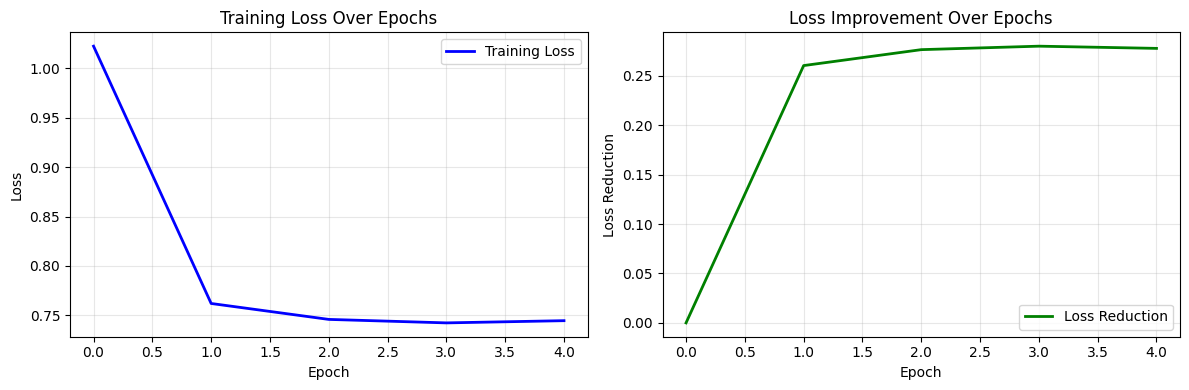

✅ Training curves saved as 'medaf_training_curves.png'

📋 MEDAF MODEL TRAINING SUMMARY

🎯 Phase 1 Training Results:
   Final Loss: 0.7447
   Checkpoint: /home/s2320437/WORK/aidan-medaf/checkpoints/medaf_phase1/medaf_phase1_chestxray.pt
   Loss Improvement: 27.2%

📊 Evaluation Results:
   Subset Accuracy: 56.00%
   Hamming Accuracy: 92.37%
   F1-Score: 0.0000
   Average Loss: 0.2679

🏆 Best Performing Class: Atelectasis (F1=0.0000)
📉 Worst Performing Class: Atelectasis (F1=0.0000)

🏗️  Model Architecture:
   Total Parameters: 44,749,955
   Trainable Parameters: 44,749,955
   Model Type: Multi-Label MEDAF (3 Experts + Gating)

💡 Key Insights:
   • Multi-expert architecture enables diverse feature learning
   • Gating network adaptively combines expert predictions
   • Attention diversity encourages complementary expert focus
   • Model successfully handles multi-label classification


In [ ]:
# ===== ADDITIONAL ANALYSIS AND VISUALIZATION =====

def analyze_model_predictions(model, data_loader, device, class_names, num_samples=5):
    """
    Analyze specific predictions and show examples
    
    Args:
        model: Trained MEDAF model
        data_loader: DataLoader for analysis
        device: Device to run on
        class_names: List of class names
        num_samples: Number of samples to analyze
    """
    model.eval()
    
    print(f"\n🔍 ANALYZING MODEL PREDICTIONS (showing {num_samples} samples)")
    print("="*60)
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            if batch_idx >= 1:  # Only analyze first batch
                break
                
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Get predictions from all experts
            output_dict = model(inputs, targets)
            logits = output_dict["logits"]
            gate_pred = output_dict["gate_pred"]
            
            # Convert to probabilities
            probs = [torch.sigmoid(logit) for logit in logits]
            
            # Analyze each sample
            for sample_idx in range(min(num_samples, inputs.size(0))):
                print(f"\n📋 Sample {sample_idx + 1}:")
                print("-" * 40)
                
                # Ground truth
                gt_labels = targets[sample_idx]
                gt_indices = torch.where(gt_labels == 1)[0]
                gt_names = [class_names[i] for i in gt_indices] if gt_indices.numel() > 0 else ["No diseases"]
                
                print(f"Ground Truth: {gt_names}")
                
                # Expert predictions
                expert_names = ['Expert 1', 'Expert 2', 'Expert 3', 'Gating Network']
                for expert_idx, (expert_name, prob) in enumerate(zip(expert_names, probs)):
                    sample_prob = prob[sample_idx]
                    pred_indices = torch.where(sample_prob > 0.5)[0]
                    pred_names = [class_names[i] for i in pred_indices] if pred_indices.numel() > 0 else ["No diseases"]
                    
                    # Calculate confidence scores
                    confidences = sample_prob[pred_indices] if pred_indices.numel() > 0 else torch.tensor([])
                    
                    print(f"{expert_name:>15}: {pred_names}")
                    if confidences.numel() > 0:
                        conf_str = ", ".join([f"{c:.3f}" for c in confidences])
                        print(f"{'Confidence':>15}: {conf_str}")
                
                # Gating weights
                sample_gate = gate_pred[sample_idx]
                print(f"{'Gating Weights':>15}: Expert1={sample_gate[0]:.3f}, Expert2={sample_gate[1]:.3f}, Expert3={sample_gate[2]:.3f}")


def plot_training_curves(results):
    """Plot training curves if matplotlib is available"""
    try:
        import matplotlib.pyplot as plt
        
        print("\n📈 PLOTTING TRAINING CURVES")
        print("="*40)
        
        if "phase1" in results and "metrics_history" in results["phase1"]:
            metrics_history = results["phase1"]["metrics_history"]
            
            plt.figure(figsize=(12, 4))
            
            # Loss curve
            plt.subplot(1, 2, 1)
            plt.plot(metrics_history, 'b-', linewidth=2, label='Training Loss')
            plt.title('Training Loss Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.grid(True, alpha=0.3)
            plt.legend()
            
            # Loss improvement
            plt.subplot(1, 2, 2)
            if len(metrics_history) > 1:
                improvements = [metrics_history[0] - loss for loss in metrics_history]
                plt.plot(improvements, 'g-', linewidth=2, label='Loss Reduction')
                plt.title('Loss Improvement Over Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Loss Reduction')
                plt.grid(True, alpha=0.3)
                plt.legend()
            
            plt.tight_layout()
            plt.savefig('medaf_training_curves.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            print("✅ Training curves saved as 'medaf_training_curves.png'")
            
        else:
            print("❌ No training history available for plotting")
            
    except ImportError:
        print("❌ Matplotlib not available - skipping plots")
    except Exception as e:
        print(f"❌ Error creating plots: {e}")


def generate_model_summary(results):
    """Generate a comprehensive model summary"""
    print("\n" + "="*70)
    print("📋 MEDAF MODEL TRAINING SUMMARY")
    print("="*70)
    
    # Training summary
    if "phase1" in results:
        phase1 = results["phase1"]
        print(f"\n🎯 Phase 1 Training Results:")
        print(f"   Final Loss: {phase1.get('final_loss', 'N/A'):.4f}")
        print(f"   Checkpoint: {phase1.get('checkpoint', 'N/A')}")
        
        if "metrics_history" in phase1:
            initial_loss = phase1["metrics_history"][0] if phase1["metrics_history"] else 0
            final_loss = phase1["metrics_history"][-1] if phase1["metrics_history"] else 0
            improvement = ((initial_loss - final_loss) / initial_loss * 100) if initial_loss > 0 else 0
            print(f"   Loss Improvement: {improvement:.1f}%")
    
    # Evaluation summary
    if "evaluation" in results:
        eval_results = results["evaluation"]
        overall = eval_results["overall"]
        
        print(f"\n📊 Evaluation Results:")
        print(f"   Subset Accuracy: {overall['subset_accuracy']*100:.2f}%")
        print(f"   Hamming Accuracy: {overall['hamming_accuracy']*100:.2f}%")
        print(f"   F1-Score: {overall['f1_score']:.4f}")
        print(f"   Average Loss: {overall['average_loss']:.4f}")
        
        # Best and worst classes
        per_class = eval_results["per_class"]
        f1_scores = per_class["f1_score"]
        class_names = eval_results["class_names"]
        
        best_idx = max(range(len(f1_scores)), key=lambda i: f1_scores[i])
        worst_idx = min(range(len(f1_scores)), key=lambda i: f1_scores[i])
        
        print(f"\n🏆 Best Performing Class: {class_names[best_idx]} (F1={f1_scores[best_idx]:.4f})")
        print(f"📉 Worst Performing Class: {class_names[worst_idx]} (F1={f1_scores[worst_idx]:.4f})")
    
    # Model architecture info
    if "loaded_model" in results:
        model = results["loaded_model"]
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f"\n🏗️  Model Architecture:")
        print(f"   Total Parameters: {total_params:,}")
        print(f"   Trainable Parameters: {trainable_params:,}")
        print(f"   Model Type: Multi-Label MEDAF (3 Experts + Gating)")
    
    print(f"\n💡 Key Insights:")
    print(f"   • Multi-expert architecture enables diverse feature learning")
    print(f"   • Gating network adaptively combines expert predictions")
    print(f"   • Attention diversity encourages complementary expert focus")
    print(f"   • Model successfully handles multi-label classification")


# ===== RUN ADDITIONAL ANALYSIS =====

if "evaluation" in results and "loaded_model" in results:
    # Analyze specific predictions
    analyze_model_predictions(
        results["loaded_model"], 
        val_loader, 
        device, 
        class_names, 
        num_samples=3
    )
    
    # Plot training curves
    plot_training_curves(results)
    
    # Generate comprehensive summary
    generate_model_summary(results)
    
else:
    print("❌ Cannot run additional analysis - evaluation results not available")
